# Logistic Regression

In [1]:
!pip install imblearn

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from imblearn.over_sampling import RandomOverSampler, SMOTE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## UDF

In [24]:
def calc_vif(X):
    '''
    Calculates the variance inflation factor (VIF) for each feature.
    VIF is used to detect multicolinearity.
    '''
    vif = pd.DataFrame()
    vif['features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif

## Import Dataset

In [67]:
accidents = pd.read_csv('data/accidents.csv', index_col=0)

In [68]:
accidents.head(2)

,RD_NO,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,...,at_intersection,at_stop_sign_or_traffic_light,is_day,is_evening,is_morning,is_night,is_day.1,is_evening.1,is_morning.1,is_night.1
0,JC343143,07/10/2019 05:56:00 PM,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,ONE-WAY,NaN,...,0,0,1,0,0,0,1,0,0,0
1,JC194776,03/21/2019 10:50:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,4.0,...,0,1,0,0,0,1,0,0,0,1


## Process Data for Model

In [53]:
predictors = ['involved_pedest_cycle',
             'is_night',
             'at_intersection',
             'has_snow_ice']


X = accidents[predictors]
y = accidents['is_fatal_or_incap']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=3)

In [55]:
scaler = MinMaxScaler()
# scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [56]:
oversampler = RandomOverSampler(sampling_strategy=0.5, random_state=3)
#oversampler = SMOTE(sampling_strategy=0.5, random_state=3)

X_over, y_over = oversampler.fit_resample(X_train_scaled, y_train)

### Hyperparameter Tuning

In [57]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
c_values =  [0.01, 0.1, 1.0, 10, 100]
params_grid = dict(solver=solvers, C=c_values)

In [58]:
log_reg = LogisticRegression(max_iter=1000, fit_intercept=True, random_state=3)

clf = GridSearchCV(log_reg, params_grid, cv=5, verbose=0, scoring='precision')

best_model = clf.fit(X_over, y_over)

In [59]:
print('Best Solver: ', best_model.best_estimator_.get_params()['solver'])
print('Best C: ', best_model.best_estimator_.get_params()['C'])

Best Solver:  newton-cg
Best C:  0.01


### Train and Predict

In [60]:
solver='newton-cg'
c=0.01

log_reg = LogisticRegression(solver=solver, C=c, max_iter=1000, fit_intercept=True, random_state=3)
log_reg.fit(X_over, y_over)
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
print('\n')
print('Recall (Scores FN): ', round(recall_score(y_test, y_pred), 4))
print('Precision (Scores FP): ', round(precision_score(y_test, y_pred), 4))
print('AUC Score: ', round(roc_auc_score(y_test, y_prob), 4))

[[55073  2477]
 [  700   365]]


Recall (Scores FN):  0.3427
Precision (Scores FP):  0.1284
AUC Score:  0.6843


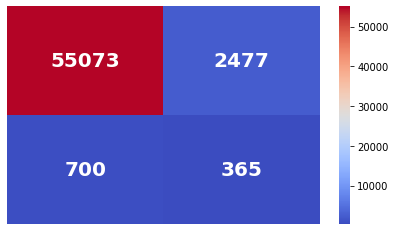

In [61]:
plt.figure(figsize=(7,4))
sns.heatmap(cf_matrix, cmap='coolwarm', annot=True, annot_kws={'size': 20, 'fontweight':'bold'}, fmt='d',
                 xticklabels=False, yticklabels=False);
#plt.savefig('img/cf_matrix.png', bbox_inches='tight')

In [62]:
coef_summary = pd.DataFrame()
coef_summary['feature_name'] = pd.Series(X.columns)
coef_summary['log_reg_coef'] = pd.Series(log_reg.coef_[0])
coef_summary.sort_values('log_reg_coef', inplace = True, ascending=False)
coef_summary

,feature_name,log_reg_coef
0,involved_pedest_cycle,2.543961
2,at_intersection,0.664786
1,is_night,0.538018
3,has_snow_ice,-0.298601


In [63]:
print('Intercept: ', log_reg.intercept_[0])

Intercept:  -1.188384757789662


### Test for Multicolinearity

In [64]:
X_over_incl_const = sm.add_constant(X_over)
model = sm.Logit(y_over, X_over_incl_const)
results = model.fit(method='bfgs')
results.summary()

         Current function value: 0.549235
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      is_fatal_or_incap   No. Observations:               345027
Model:                          Logit   Df Residuals:                   345022
Method:                           MLE   Df Model:                            4
Date:                Sun, 31 Jan 2021   Pseudo R-squ.:                  0.1371
Time:                        18:19:05   Log-Likelihood:            -1.8950e+05
converged:                      False   LL-Null:                   -2.1961e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1954      0.005   -242.767      0.000      -1.205      -1.186
x1             2.5849      0.013    204.251      0.000       2.560       2.610
x2             0.5458      0.010     55.430      0.000       0.527       0.565
x3             0.6877      0.018     37.558      0.000       0.652       0.724
x4            -0.3092      0.020    -15.577      0.000      -0.348      -0.270
==============================================================================
"""

In [65]:
X_over_df = pd.DataFrame(X_over, columns=X.columns)
calc_vif(X_over_df)

,features,VIF
0,involved_pedest_cycle,1.031444
1,is_night,1.035073
2,at_intersection,1.021832
3,has_snow_ice,1.010128
